<a href="https://colab.research.google.com/github/yossireuven/sl-github/blob/master/Regression_%26_Regularization_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yandex Data Science School
## Linear Regression & Regularization Exercise.
### Written by Dr. Hanan Shteingart.

## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implemntation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Exercise 1 - Ordinary Least Square

In [0]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.datasets import load_boston
from sklearn import preprocessing
boston = load_boston()

In [0]:
print('n: {} (# of samples)\np: {}  (# of features)'.format(boston.data.shape[0],boston.data.shape[1]))

n: 506 (# of samples)
p: 13  (# of features)


In [0]:
class OrdinaryLinearRegression:
    def __init__(self):
        self.w = None
        self.X = None
        self.y = None
    
    def fit(self, X, y):
        self.X = np.c_[np.ones(X.shape[0]), X]    # add 1's column (bias)
        self.y = y
        self.w = np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(X), X)), np.transpose(X)), y)
        
    def predict(self, X):
        return np.matmul(X, self.w)
    
    def score(self):
        pass

In [0]:
olr = OrdinaryLinearRegression()
olr.fit(boston.data, boston.target)
print('Training MSE = {:.2e}'.format(mean_squared_error(boston.target, olr.predict(boston.data))))

Training MSE = 2.42e+01


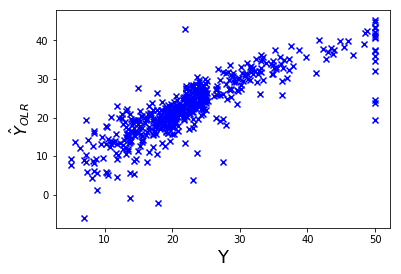

In [0]:
plt.scatter(boston.target, olr.predict(boston.data),  color='b', marker='x')
plt.xlabel('Y', fontsize=18)
plt.ylabel(r'$\hat Y_{OLR}$', fontsize=16)
plt.show()

In [0]:
mse_e = []
rs = ShuffleSplit(n_splits=20, test_size=.25, random_state=0)
for train_index, test_index in rs.split(boston.data):
    olr.fit(boston.data[train_index], boston.target[train_index])
    mse_e.append(mean_squared_error(boston.target[test_index], olr.predict(boston.data[test_index])))
print('Average MSE = {} [20 Iterations, (75-25) split]'.format(np.average(mse_e)))

Average MSE = 25.039747482719108 [20 Iterations, (75-25) split]


In [0]:
class OrdinaryLinearRegressionGradientDescent:
    def __init__(self, lr=0.11, n_itr=100):
        self.w = None
        self.mse = None
        self.lr = lr
        self.n_itr=n_itr
    
    def fit(self, X, y):
        #X = (X - X.mean()) / X.std()
        #X = (X - X.min()) / (X.max() - X.min())
        X = X / X.mean(axis=0) 
        X = np.c_[np.ones(X.shape[0]),X]
        self.w = np.zeros(X.shape[1])
        norm = 1.0/X.shape[0]
        for i in range(self.n_itr):
            Xw = np.dot(X, self.w)
            self.w = self.w - self.lr * norm * np.dot(X.T, Xw-y)
        self.mse = mean_squared_error(y, np.dot(X, self.w))
        # print('learning_rate = {} | mse = {} | # of iterations = {}'.format(self.lr, self.mse, self.n_itr))
        
    def predict(self, X):
        return np.matmul(X, self.w)
    
    def score(self):
        pass

In [0]:
olr_gd = OrdinaryLinearRegressionGradientDescent()
olr_gd.fit(boston.data, boston.target)

Optimal learning rate = 0.11 | MSE = 34.19



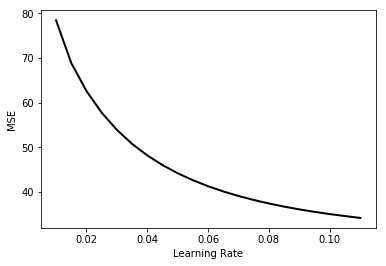

In [0]:
mses = [np.inf]
rates = np.linspace(0,5,1000)[1:]
for lr_ in rates:
    olr_gd = OrdinaryLinearRegressionGradientDescent(lr=lr_, n_itr=100)
    olr_gd.fit(boston.data, boston.target)
    if abs(olr_gd.mse - mses[-1]) < 0.4:
        break
    mses.append(olr_gd.mse)
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.plot(rates[:len(mses)], mses, linewidth=2, c='k');
print('Optimal learning rate = {:.2f} | MSE = {:2.2f}\n'.format(rates[:len(mses)][-1], mses[-1]))

    * What is the effect of learning rate? 
        -> Defining the step size, too big of a step and we may overshot the minimum, too small and it will take to long to converge
    * How would you find number of iteration automatically? 
        -> Few ideas:
            - stop when the improvment between iterations smaller from a pre-defined threshold
            - stop when the mse get to 'close enough' distance from 0
    * Gradient Descent does not work well when features are not scaled evenly - why?
        -> N/A

## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\frac{1}{N}\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2$

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$

## Exercise 3 - Lasso Linear Regression

As we've seen in class, Lasso Regression is a regularization technique with $L_1$ penalty on weights. This techniques creates sparse weights (some weights become effectively zero). Programming a Lasso solver is a challange and is left as an optional exercise below.
This exercise will focus on the analysis of the different regularization techniques over a toy problem using the scikit-learn implementation.

### Data generation: 1-D Polynomal Regression
```
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

```

* Use the preprocessing transformer `sklearn.preprocessing.PolynomialFeatures` in order to create a feature space. Note, you can use `sklearn.pipeline.Pipeline` in order to create an effective model which does the preprocessing (not essential).
* Use `sklearn.model_selection.cross_val_score` to evaluate each of the linear model provided by Scikit-learn (`from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV`) and compare the performance over the different `degrees`. To do so, create a 3x3 plot where each row correspond to one model and each column to one degree. Each plot should plot the train data as well as the true model and the fitted one (use 100 points in the range [0,1]) and the CV MSE. What is the take home message? (Note: RidgeCV and LassoCV do an internal cross-validation to determin the regularization parameter.)
* Weights spectrum: change the `alpha` parameter gradually (on a logartithmic scale) and observe how the coefficients change for `degrees=5` over alpha for Ridge and Lasso. What is the take home message?

In [0]:
from sklearn.linear_model import (LinearRegression, RidgeCV, LassoCV)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [0]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1
x_text = np.linspace(0,1,100)

In [0]:
estimators = [('OLS', LinearRegression()),
              ('Ridge', RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])),
              ('Lasso', LassoCV())]

In [0]:
estimators = [('Lasso', LassoCV(cv=5))]

In [0]:
# colors = ['teal', 'yellowgreen', 'gold']
# plt.plot(X, true_fun(X), color='cornflowerblue', linewidth=2, label="ground truth")
# plt.scatter(np.sort(X[:20]), true_fun(np.sort(X[:20])), color='navy', s=30, marker='o', label="training points")

plt.figure(figsize=(21, 5))
for name, estimator in estimators:
    for count, degree in enumerate(degrees):
        plt.subplot(estimators.index((name, estimator))+1, 3, count+1)
        model = make_pipeline(PolynomialFeatures(degree), estimator)
        model.fit(x[:, np.newaxis], true_fun(x))
        cv = cross_val_score(model, X[:, np.newaxis], y, cv=5)
        plt.plot(x_text, model.predict(x_text[:, np.newaxis]), linewidth=2, c='g', label="Model")
        plt.plot(x_text, true_fun(x_text), linewidth=1, c='b', label="True function")
        plt.scatter(X, y, c='r', label="Samples")
        plt.xlim([0,1])
        plt.ylim([-2,2])
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Degree {}\nMSE = {:.2e}".format(degree, -cv.mean()))
        plt.legend(loc="best")

plt.show()